In [1]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

2023-05-12 23:02:52.070020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:


def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) 
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1 
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise 
    return time, series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
time, series = generate_time_series(10000, n_steps + 1)

In [4]:
time.shape, series.shape

((51,), (10000, 51, 1))

In [5]:
# 7k/10k for training set
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]

# Next 2k/10k for validation set
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]

# Next 1k/10k for test set
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

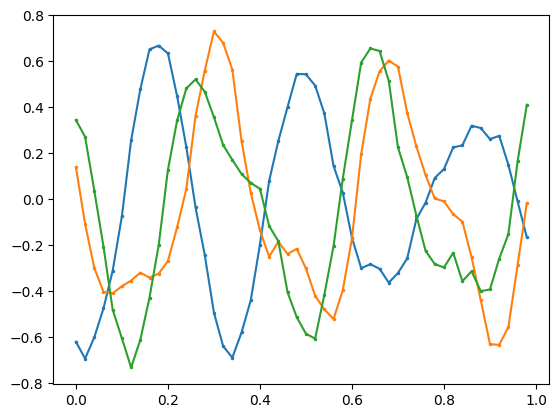

In [6]:
# There are 7K TS data, plotting only 3 of them

plt.plot(time[:n_steps], X_train[0, :, 0], marker='.', markersize=3)
plt.plot(time[:n_steps], X_train[1, :, 0], marker='.', markersize=3)
plt.plot(time[:n_steps], X_train[2, :, 0], marker='.', markersize=3)

In [7]:
print("Train ", X_train.shape, y_train.shape)
print("Valid ", X_valid.shape, y_valid.shape)
print("Test ", X_test.shape, y_test.shape)

Train  (7000, 50, 1) (7000, 1)
Valid  (2000, 50, 1) (2000, 1)
Test  (1000, 50, 1) (1000, 1)


In [8]:
# Use existing validation set itself to get an idea about mse

y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

2023-05-12 23:02:56.380785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.02036216

In [9]:
y_pred.shape, y_valid.shape, X_valid.shape

((2000, 1), (2000, 1), (2000, 50, 1))

# Fully Connected Network as shown below

In [10]:
# building simple sequential model to consume vector [50, 1] and produce 1 vector, the next 51st value
# This is basically linear regression
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 1ms/step - loss: 0.1121 - accuracy: 0.0000e+00 - val_loss: 0.0555 - val_accuracy: 0.0000e+00
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0408 - accuracy: 0.0000e+00 - val_loss: 0.0326 - val_accuracy: 0.0000e+00
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0260 - accuracy: 0.0000e+00 - val_loss: 0.0225 - val_accuracy: 0.0000e+00
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0188 - accuracy: 0.0000e+00 - val_loss: 0.0172 - val_accuracy: 0.0000e+00
Epoch 5/20
219/219 [==============================] - 0s 997us/step - loss: 0.0152 - accuracy: 0.0000e+00 - val_loss: 0.0145 - val_accuracy: 0.0000e+00
Epoch 6/20
219/219 [==============================] - 0s 997us/step - loss: 0.0130 - accuracy: 0.0000e+00 - val_loss: 0.0125 - val_accuracy: 0.0000e+00
Epoch 7/20
219/219 [==============================] - 0s 951us/step - loss: 0.0113 - accuracy: 0

In [11]:
# use model to predict 51st TS data point
y1 = model.predict(X_test)

# calculate mse to get baseline metric
np.mean(keras.losses.mean_squared_error(y_test, y1))

32/32 [==============================] - 0s 639us/step


0.004583753

In [12]:
y1.shape, y_test.shape, X_valid[:, -1].shape, y_valid.shape

((1000, 1), (1000, 1), (2000, 1), (2000, 1))

In [13]:
# build single layer RNN model
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[50, 1]) # input_shape=[None, 1] is also accepted
])

# compile
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

# Fit the model using 7K data to train and 2k data to validate
model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
219/219 [==============================] - 2s 5ms/step - loss: 0.1259 - accuracy: 0.0000e+00 - val_loss: 0.1091 - val_accuracy: 0.0000e+00
Epoch 2/30
219/219 [==============================] - 1s 4ms/step - loss: 0.0961 - accuracy: 0.0000e+00 - val_loss: 0.0801 - val_accuracy: 0.0000e+00
Epoch 3/30
219/219 [==============================] - 1s 4ms/step - loss: 0.0667 - accuracy: 0.0000e+00 - val_loss: 0.0513 - val_accuracy: 0.0000e+00
Epoch 4/30
219/219 [==============================] - 1s 4ms/step - loss: 0.0400 - accuracy: 0.0000e+00 - val_loss: 0.0291 - val_accuracy: 0.0000e+00
Epoch 5/30
219/219 [==============================] - 1s 4ms/step - loss: 0.0242 - accuracy: 0.0000e+00 - val_loss: 0.0204 - val_accuracy: 0.0000e+00
Epoch 6/30
219/219 [==============================] - 1s 4ms/step - loss: 0.0195 - accuracy: 0.0000e+00 - val_loss: 0.0183 - val_accuracy: 0.0000e+00
Epoch 7/30
219/219 [==============================] - 1s 4ms/step - loss: 0.0180 - accuracy: 0.0000e

In [15]:
# for each of 1k data, predict 51st value
y2 = model.predict(X_test)
print(y2.shape, y_test.shape)

# calculate mse metric
print(np.mean(keras.losses.mean_squared_error(y_test, y2)))

32/32 [==============================] - 0s 2ms/step
(1000, 1) (1000, 1)
0.011286796


# LTSM

In [16]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[50, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
219/219 [==============================] - 7s 21ms/step - loss: 0.1440 - accuracy: 0.0000e+00 - val_loss: 0.1422 - val_accuracy: 0.0000e+00
Epoch 2/30
219/219 [==============================] - 4s 19ms/step - loss: 0.1432 - accuracy: 0.0000e+00 - val_loss: 0.1421 - val_accuracy: 0.0000e+00
Epoch 3/30
219/219 [==============================] - 4s 20ms/step - loss: 0.1425 - accuracy: 0.0000e+00 - val_loss: 0.1413 - val_accuracy: 0.0000e+00
Epoch 4/30
219/219 [==============================] - 4s 19ms/step - loss: 0.1397 - accuracy: 0.0000e+00 - val_loss: 0.1372 - val_accuracy: 0.0000e+00
Epoch 5/30
219/219 [==============================] - 4s 19ms/step - loss: 0.1271 - accuracy: 0.0000e+00 - val_loss: 0.1131 - val_accuracy: 0.0000e+00
Epoch 6/30
219/219 [==============================] - 4s 19ms/step - loss: 0.1083 - accuracy: 0.0000e+00 - val_loss: 0.0962 - val_accuracy: 0.0000e+00
Epoch 7/30
219/219 [==============================] - 4s 20ms/step - loss: 0.0948 - accuracy: 

In [ ]:
y4 = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y4[:, :, 0], y_test))

# Gated Recurrent Unit

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[50, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))


In [ ]:
y5 = model.predict(X_test)

In [ ]:
y5.shape

In [ ]:
np.mean(keras.losses.mean_squared_error(y5[:, :, 0], y_test))